<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/97_46(%EC%A0%84%EC%B2%98%EB%A6%AC%2B%EC%A6%9D%EA%B0%95%2BW2V%2BGRU%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 불러오기

In [ ]:
#모듈 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import re
import gensim

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D, Dropout,SpatialDropout1D,Conv1D,concatenate,Flatten

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# 데이터 불러오기

In [ ]:
#데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
#데이터 열 확인
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
# train 데이터 확인하기
train_data.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
#테스트 데이터 확인하기
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# 텍스트 전처리

In [ ]:
pip install contractions

     |████████████████████████████████| 266kB 23.4MB/s 
     |████████████████████████████████| 327kB 53.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85395 sha256=681cb52d24b115924037d9ab3d6217272da2eb8d9c66a9fc3733bd601ee69ff2
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
#텍스트 전처리
from nltk.corpus import stopwords  
import contractions

def clean_text(text):
    #text = contractions.fix(text)
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"[\n\t]"," ", text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'[`~!@#$%^&*{}()[]\":;?><,/]', " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}"," ", text)
    if len(text) < 4000:
        text = contractions.fix(text)
    else:
        text = contractions.fix(text[:4000])
    return text

#불용어
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [ ]:
train_data['comment_text'] = train_data['comment_text'].map(lambda txt : clean_text(txt))

In [ ]:
X_train = train_data.comment_text
y_train = train_data[["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]].values

# 데이터 증강

In [ ]:
# 부족한 데이터 확인하기 부족한 데이터 확인하기
lack_feat = train_data.loc[(train_data['threat'] == 1) | (train_data['identity_hate']==1) | (train_data['severe_toxic']==1)].copy()
print(lack_feat.shape)
lack_feat.head()

(2987, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? Archangel WHite ...,1,0,1,0,1,1
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
79,003217c3eb469ba9,Hi! I am back again! Last warning! Stop undoin...,1,0,0,1,0,0
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1


In [ ]:
pip install numpy requests nlpaug

     |████████████████████████████████| 399kB 22.0MB/s 


In [ ]:
import nlpaug.augmenter.word as naw
aug = naw.WordEmbsAug(model_type='glove', model_path='/content/drive/MyDrive/glove.6B.300d.txt', stopwords=stop_words)

In [ ]:
augmented_data = aug.augment(lack_feat['comment_text'].tolist())

In [ ]:
lack_feat['comment_text'].tolist()[1]

'You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two ways, why you do erased my comment about WW, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone... - If you are anti-semitian, than shave your head bald and go to the skinhead meetings! - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! - First and last warning, you fucking gay - I won t appreciate if any more nazi shwain would write in my page! I don t wish to talk to you anymore! Beware of the Dark Side!'

In [ ]:
augmented_data[1]

'You are gay or antisemmitian? Archangel WHite Tiger Meow! Greetingshhh! Uh, there are two make, why you do erased my comment about WW, that apology was brutally slaying of Jews and not discriminatory / Gypsys / Slavs / someone. .. - If you are anti - semitian, than shave your turn bald and go to the skinhead meetings! - If you sure words of the Bible, that homosexuality is a shootings gluttony, make a pentagram mosb103 on your forehead go to the satanistic masses with your gay pals! - First and last warning, you fucking gay - I won t appreciate if any more nazi shwain hoped write in my page! I don t wish to talk to you anymore! Beware of the Dark Side!'

In [ ]:
len(augmented_data)

2987

In [ ]:
lack_feat['comment_text'] = augmented_data

In [ ]:
train_data = pd.concat([train_data, lack_feat], ignore_index=True)
print(train_data.shape)

(162558, 8)


In [ ]:
train_data.to_pickle('/content/drive/MyDrive'+'/aug_train_df.pkl')

In [ ]:
import pickle
train_df = pd.read_pickle('/content/drive/MyDrive'+'/aug_train_df.pkl')

In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D aww! He matches this background colour I m s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I m really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can t make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
columns = list(train_df.columns)
columns = columns[2:]
histo = pd.DataFrame(train_df[columns].sum().sort_values(ascending=False))
histo

,0
toxic,18149
obscene,10842
insult,10257
severe_toxic,3190
identity_hate,2810
threat,956


In [ ]:
X_train = train_df.comment_text
y_train = train_df[["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]].values

In [ ]:
print("X train shape : ", X_train.shape)
print("y train shape : ", y_train.shape)

X train shape :  (162558,)
y train shape :  (162558, 6)


# 토큰화 작업하기

In [ ]:
max_features=70000
maxlen=200
embed_size=300


tok=Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train)

X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train),
                        maxlen = maxlen, truncating = "pre")


In [ ]:
word_index = tok.word_index
len(word_index)

173797

In [ ]:
word_index = {e:i for e,i in word_index.items() if i <= max_features}

In [ ]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-07 02:10:49--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.115.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.115.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  93.0MB/s    in 18s     

2021-04-07 02:11:06 (89.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [ ]:
embedding_matrix = np.zeros((max_features, 300))

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i-1] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.

# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = SpatialDropout1D(0.1)(layer)
layer = Bidirectional(GRU(128, return_sequences=True))(layer)
#layer = Bidirectional(GRU(128, return_sequences=True))(layer)
layer = Conv1D(128, kernel_size = 3)(layer)   
#layer = Conv1D(64, kernel_size = 3)(layer)  
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
#layer = Dense(32,activation='relu')(layer)
#layer = Flatten()(layer)
layer = Dropout(0.2)(layer)
layer= Dense(6, activation="sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     21000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     330240      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
file_path = '/content/drive/MyDrive' +'/data'
checkpoint = ModelCheckpoint(file_path, monitor= 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor= 'val_loss', patience= 1)

In [ ]:
hist = model.fit(X_train, y_train, epochs=4,batch_size=32, validation_split=0.2,callbacks=[checkpoint, early_stop])

Epoch 1/4
4064/4064 [==============================] - 942s 223ms/step - loss: 0.0761 - accuracy: 0.7968 - val_loss: 0.1357 - val_accuracy: 0.9895

Epoch 00001: val_loss improved from inf to 0.13570, saving model to /content/drive/MyDrive/data


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/assets


Epoch 2/4
4064/4064 [==============================] - 909s 224ms/step - loss: 0.0383 - accuracy: 0.8918 - val_loss: 0.1145 - val_accuracy: 0.9872

Epoch 00002: val_loss improved from 0.13570 to 0.11449, saving model to /content/drive/MyDrive/data


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/assets


Epoch 3/4
4064/4064 [==============================] - 917s 226ms/step - loss: 0.0302 - accuracy: 0.7663 - val_loss: 0.1218 - val_accuracy: 0.9154

Epoch 00003: val_loss did not improve from 0.11449


In [ ]:
model.save('/content/drive/MyDrive/toxic1_model0407-2.h5')

# 모델 예측하기

In [ ]:
test_data = test_data['comment_text']
test_final = tok.texts_to_sequences(test_data)
test_padded =sequence.pad_sequences(test_final, maxlen=200)

In [ ]:
y_pred = model.predict(test_padded)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission19.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

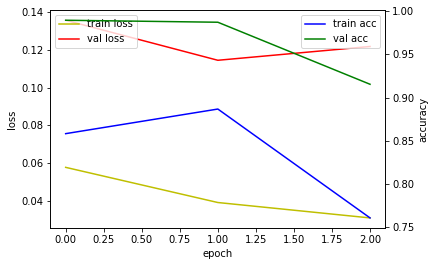

In [ ]:
acc_loss_plot(hist)